---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

# Homework 1 - Supervised Deep Learning
---
---

## Regression task

In [1]:
#################
#### IMPORTS ####
#################

# Dataframes and Arrays
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold


In [2]:
# Setting the values of the seeds for reproducibility
torch.manual_seed(2012264)    
np.random.seed(2012264)


In [3]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cpu


### Dataset and DataLoader 

In [4]:
class CsvDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        self.data = pd.read_csv(csv_file).to_numpy()
        self.names = pd.read_csv(csv_file).columns
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    

In [5]:
# Remove anything in the data folder
!rm -rf regression_dataset

# DOWNLOADING THE DATA
data_url = "https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/"

# wget without showing the output, I already checked it works
!wget -P regression_dataset {data_url}train_data.csv &> /dev/null # download training set
!wget -P regression_dataset {data_url}test_data.csv  &> /dev/null # download test set


In [6]:
# We only use ToTensor() transform for this task
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset  = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)


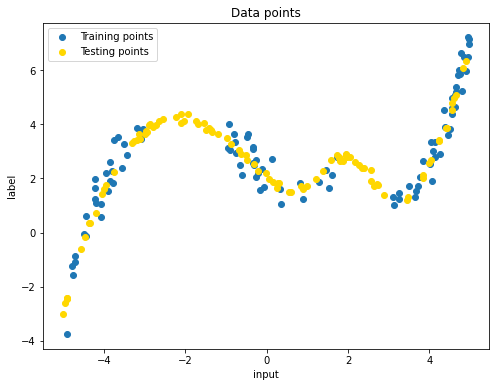

In [7]:
fig = plt.figure(figsize=(8,6))

# Plotting training and test points
plt.scatter(train_dataset.data[:,0], train_dataset.data[:,1], label='Training points')
plt.scatter(test_dataset.data[:,0], test_dataset.data[:,1], label='Testing points', color='gold')

plt.title('Data points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()


### Building the Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self, Ni, No, Nhs):
        """
        Ni - Input size  (INT)
        No - Output size (INT)
        Nhs - Hidden layers (LIST OF INTEGERS)
        """
        super().__init__()
        nhidden = len(Nhs) # number of hidden layers
        # Creating an array of layers
        Ns = [Ni] + Nhs + [No]
        # First layer
        self.fc1 = nn.Linear(in_features=Ns[0], out_features=Ns[1])
        
        # Hidden layers
        self.hidden = nn.ModuleList()
        for h in range(nhidden-1):
            self.hidden.append(nn.Linear(in_features=Ns[h+1], out_features=Ns[h+2]))
            
        # Last layer
        self.out = nn.Linear(in_features=Ns[-2], out_features=Ns[-1])
        
        self.act = nn.Sigmoid()
    
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        
        for h in range(len(self.hidden)):
            x = self.act(self.hidden[h](x))
        
        x = self.out(x)
        return x
    
    def fit(self, data, epochs, folds, torch_loss, printfreq, lr0, reg_term = 0,plotlosses = False):
        # Define the loss function
        loss_fn = torch_loss

        # Define the optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr0, weight_decay= reg_term)
        
        train_loss_log = []
        val_loss_log   = []
        for epoch in range(epochs):
            ### TRAIN
            train_loss = []
    
            net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
            for sample_batched in data:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
        
                kf = KFold(n_splits=folds)
                kf.get_n_splits(x_batch)
        
                loss = 0
                for train_index, val_index in kf.split(x_batch):
                    x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                    y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                    # Forward pass
                    out = self(x_batch_train)
        
                    # Compute loss
                    loss = loss + loss_fn(out, y_batch_train)/folds

                # Backpropagation
                net.zero_grad()
                loss.backward()

                # Update the weights
                optimizer.step()

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)

            # Save average train loss
            train_loss = np.mean(train_loss)
    
            if printfreq!=0 and epoch%printfreq == 0:
                print('#################')
                print(f'# EPOCH {epoch}')
                print('#################')
                print(f"AVERAGE TRAIN LOSS: {train_loss}")
            train_loss_log.append(train_loss)
        
            ### VALIDATION
            val_loss= []
            net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in data:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)

                    kf = KFold(n_splits=folds)
                    kf.get_n_splits(x_batch)
        
                    loss = 0
                    for train_index, val_index in kf.split(x_batch):
                        x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                        y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                        # Forward pass
                        out = self(x_batch_val)

                        # Compute loss
                        loss = loss + loss_fn(out, y_batch_val)/folds
                
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
        
                # Save average validation loss
                val_loss = np.mean(val_loss)
                if printfreq!=0 and epoch%printfreq == 0:
                    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
                    print('')
                val_loss_log.append(val_loss)
                
        if plotlosses:
            plt.title('Losses')
            xvalues = np.arange(0,epochs)
            plt.plot(xvalues, val_loss_log  , label='Validation error')
            plt.plot(xvalues, train_loss_log, label='Training error')
            plt.legend()
            plt.show()
        
        return train_loss_log[-1], val_loss_log[-1]
    
    def show_regression(self,dloader):
        # Input vector
        x_vec = torch.linspace(np.min(dloader.dataset.data[:,0]),
                               np.max(dloader.dataset.data[:,0]),1000)
        x_vec = x_vec.to(device)
        x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector

        net.eval()
        with torch.no_grad(): # turn off gradients computation
            y_vec = self(x_vec)

        # Convert x_vec and y_vec to numpy one dimensional arrays
        x_vec = x_vec.squeeze().cpu().numpy()
        y_vec = y_vec.squeeze().cpu().numpy()

        # Plot output
        plt.plot(x_vec, y_vec, label='Network output',color='red')
        plt.scatter(dloader.dataset.data[:,0], dloader.dataset.data[:,1], label='Training points')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.legend()
        plt.show()


In [9]:
# Quick test for the NN structure
net = Net(1,1,[20,20,20])
print(net)


Net(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (hidden): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
  (act): Sigmoid()
)


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle=True, num_workers=0)


#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 11.365766525268555
AVERAGE VAL LOSS: 11.264439582824707

#################
# EPOCH 1000
#################
AVERAGE TRAIN LOSS: 1.61452317237854
AVERAGE VAL LOSS: 1.5181818008422852

#################
# EPOCH 2000
#################
AVERAGE TRAIN LOSS: 1.4482287168502808
AVERAGE VAL LOSS: 1.2642005681991577

#################
# EPOCH 3000
#################
AVERAGE TRAIN LOSS: 0.8231009244918823
AVERAGE VAL LOSS: 1.01639986038208

#################
# EPOCH 4000
#################
AVERAGE TRAIN LOSS: 0.27649134397506714
AVERAGE VAL LOSS: 0.30070069432258606



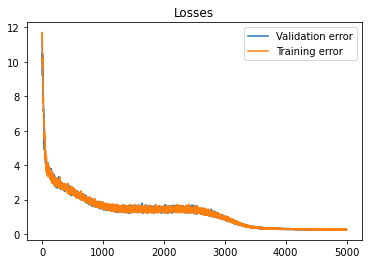

(0.2522002, 0.2557922)

In [11]:
net.fit(train_dataloader,5000,3,nn.MSELoss(),1000,1e-3,reg_term = .0001,plotlosses=True)


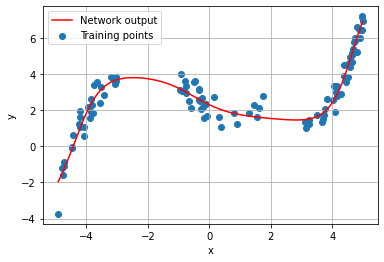

In [12]:
net.show_regression(train_dataloader)


## Grid-search

In [13]:
# Hyperparameters for the gridsearch:
grid_lrs = [1e-2,1e-3,1e-4,1e-5,1e-6]
grid_losses = [nn.L1Loss(),nn.MSELoss()]
grid_regs = [1e-4,1e-5,0]
grid_hlayers = [[10],[20],[30],[10,10],[20,20],[10,10,10],[20,20,20]]

best_train_loss = 1000000
best_val_loss   = 1000000

i = 0

for grid_lr in grid_lrs:
    for grid_loss in grid_losses:
        for grid_reg in grid_regs:
            for grid_hlayer in grid_hlayers:
                # For every possible combination of hyperparameters...
                net = Net(1,1,grid_hlayer)
                grid_train_loss, grid_val_loss = net.fit(train_dataloader,4000,3,grid_loss,0,grid_lr,reg_term = grid_reg)
                
                if grid_val_loss < best_val_loss:
                    best_val_loss = grid_val_loss
                    
                    # Save the best combination of the hyperparameters in a dictionary
                    # so we can inspect the best model later
                    best_config = {
                              "lr":            grid_lr,
                              "loss":          grid_loss,
                              "reg":           grid_reg,
                              "hidden layers": grid_hlayer }
                
                if False: # Set to False, too much useless information displayed
                    print('---------------------')
                    print('Configuration', i)
                    print(' Validation loss: ', grid_val_loss)
                    print(' Lr =           ', grid_lr)
                    print(' Loss =         ', grid_loss)
                    print(' Reg =          ', grid_reg)
                    print(' hidden_layers =', grid_hlayer)
                    print('')
                
                i = i + 1
                

In [14]:
print('Best model found: ')
print(best_config)


{'lr': 0.01, 'loss': MSELoss(), 'reg': 1e-05, 'hidden layers': [10, 10]}


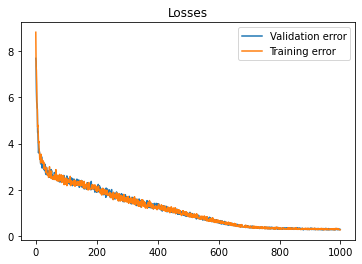

(0.25961128, 0.27269086)

In [16]:
# Initialize and train the model with the best configurations, so we can see how it performs
net = Net(1,1,best_config["hidden layers"])
net.fit(train_dataloader,1000,3,best_config["loss"],0,best_config["lr"],reg_term = best_config["reg"],plotlosses=True)


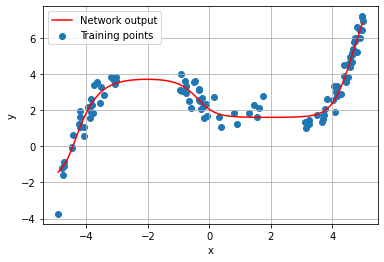

In [17]:
net.show_regression(train_dataloader)


## Appendix

### Test: K-Fold Cross-validation

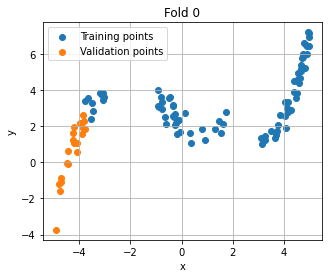

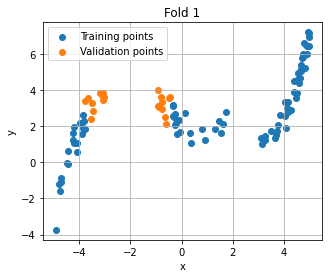

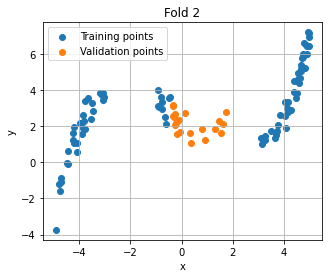

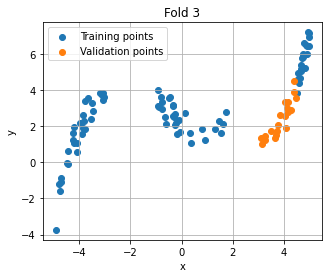

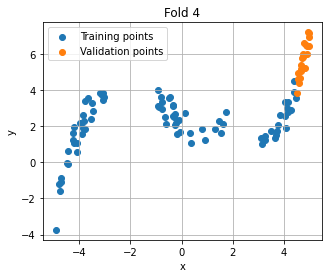

In [18]:
# Create a copy of the data array
kfold_data = train_dataset.data

# Ordering the copy of the data array, so that it's easier to visualize if the kfold worked or not
kfold_data = kfold_data[kfold_data[:,0].argsort()]
k = 0

kf = KFold(n_splits=5)
kf.get_n_splits(kfold_data[:,0])
for train_index, val_index in kf.split(kfold_data[:,0]):
    #print("Fold "+str(k))
    #print("   VAL:", val_index)
    X_train, X_val = kfold_data[:,0][train_index], kfold_data[:,0][val_index]
    y_train, y_val = kfold_data[:,1][train_index], kfold_data[:,1][val_index]
    
    plt.figure(figsize=(5,4))
    plt.title("Fold "+str(k))
    plt.scatter(X_train, y_train, label='Training points')
    plt.scatter(X_val, y_val, label='Validation points')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.show()
    k = k + 1
    

In [19]:
# K-Fold seems to be successfully applied, of course for the training of the model, 
# the dataset will be randomly shuffled before


### Polynomial model

In [20]:
# y = [a] + [b]x + [c]x^2 + noise
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    #print(x_matrix)
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

def least_squares(x, y, pol_order, reg_term):
    """
    Implement the least square algorithm to fit a polynomial function of order "pol_order"
    INPUT
        x: training x data
        y: training y data
        pol_order: order of the fitting polynomial function
        reg_term: regularization term
    OUTPUT
        beta_est: estimated parameter vector
    """
    
    # Create the Y matrix
    Y = y.reshape(len(y), 1)
    # Create the X matrix
    X = np.array([x**i for i in range(pol_order+1)]).transpose()
    
    # RLS algorithm
    gram_matrix = np.matmul(X.transpose(), X) + reg_term * np.identity(X.shape[1])
    gram_matrix_inv = np.linalg.inv(gram_matrix)
    temp = np.matmul(gram_matrix_inv, X.transpose())
    beta_est = np.matmul(temp, Y)
    
    return beta_est.squeeze()

def polynomial_model_compute_valerr(params,valset_x,valset_y):
    """
    Computes the MSE of the polinomial found (coefficients) with the testing set
    INPUT
        params: coefficients of the polinomial
        valset_x: x-values of the validation set
        valset_y: y-values of the validation set
    """
    err = 0
    for i in range(len(valset_y)):
        predicted = 0
        for g in range(len(params)):
            predicted = predicted + params[g]*valset_x[i]**g
        err = err + (valset_y[i] - predicted)**2
        
    return np.mean(err)


In [21]:
pgrademax = 20
errs = []
lowest_err = 100000
best_grade = 0

for pgrade in range(1,pgrademax):
    params = least_squares(train_dataloader.dataset.data[:,0], train_dataloader.dataset.data[:,1], pgrade, 0)
    errs.append(polynomial_model_compute_valerr(params,test_dataloader.dataset.data[:,0], test_dataloader.dataset.data[:,1]))
    
    if errs[-1] < lowest_err:
        best_grade = pgrade
        lowest_err = errs[-1]
        best_betas = params
        

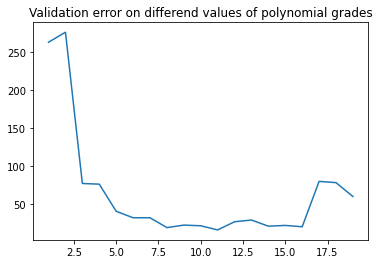

In [22]:
plt.title("Validation error on differend values of polynomial grades")
plt.plot(np.arange(1,pgrademax,1),errs)


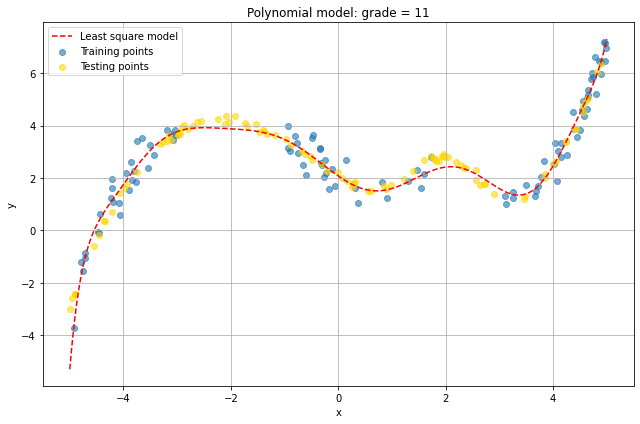

In [23]:
plt.figure(figsize=(9,6))

x_highres = np.linspace(-5,5,1000)
plt.plot(x_highres, poly_model(x_highres, best_betas), color='red', ls='--', label='Least square model')
plt.scatter(train_dataset.data[:,0], train_dataset.data[:,1], label='Training points', alpha=0.6)
plt.scatter(test_dataset.data[:,0], test_dataset.data[:,1], label='Testing points', color='gold', alpha=0.6)

plt.title('Polynomial model: grade = '+str(best_grade))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
